# Forest Fire Computer Vision Detection

- Introduction to Deep Learning Final Project
- Viacheslav Sergeev <viacheslav.sergeev@colorado.edu>
- University of Colorado Boulder

## Problem Statement

Forest fire is a growing environment threat damaging ecosystems and releasing CO2 emissions. Quick detection is crucial to minimize these impacts.

I need to create a base model for automated detection of signs of fire from cameras and drones to spot the fire early and trigger alerts.

I will create a computer vision deep machine learning model to classify if there is a forest fire on the photo.

## Data Description

### Source

I use Kaggle dataset `Forest_Fire_BigData` ([link](https://www.kaggle.com/datasets/mohammedborhanuddin/forest-fire-bigdata)) by Mohammed Borhan Uddin. As of project development date 10/27/24 there is no code attached to this dataset in Kaggle.


### Kaggle Description

> I collected this dataset for a research purpose and this dataset contains detailed records of forest fires, offering valuable data for understanding and predicting fire occurrences. It can be used for various purposes, including fire detection, fire risk modeling, and classification tasks. The dataset includes numerous features related to the geographic, environmental, and weather conditions that impact forest fires, making it suitable for use in machine learning models, particularly for fire detection and classification tasks.

### Description

The dataset has two folders of images: `fire_images` and `non_fire_images` containing photos with fire and without fire respectively.  

# 1. Exploratory Data Analysis (EDA)

## 1.1 Data Loading

I download the dataset directly using Kaggle API.

In [2]:
import kagglehub

path = kagglehub.dataset_download("mohammedborhanuddin/forest-fire-bigdata")

print("Path to dataset files:", path)

100%|██████████| 24.1M/24.1M [00:01<00:00, 15.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohammedborhanuddin/forest-fire-bigdata/versions/1


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

## 1.2 Dataset Balance

Check if the dataset is balanced

In [4]:
path = os.path.join(path,'Forest_Fire_BigData')
negative_path = os.path.join(path, 'non_fire_images')
positive_path = os.path.join(path, 'fire_images')

negative_images = os.listdir(negative_path)
positive_images = os.listdir(positive_path)

print(f"Negative images: {len(negative_images)}, Positive images: {len(positive_images)}")

Negative images: 904, Positive images: 928


The dataset labels perfectly 50/50 balanced which means that there is no necessity to apply dataset balancing and unbalanced ML training techniques.

## 1.3 Data Overview

I look at the random sample of photos for every label.

In [5]:
import random

def show_label_images(title: str, images: list, path):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        img = cv2.imread(os.path.join(path, images[random.randint(0, len(images) - 1)]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


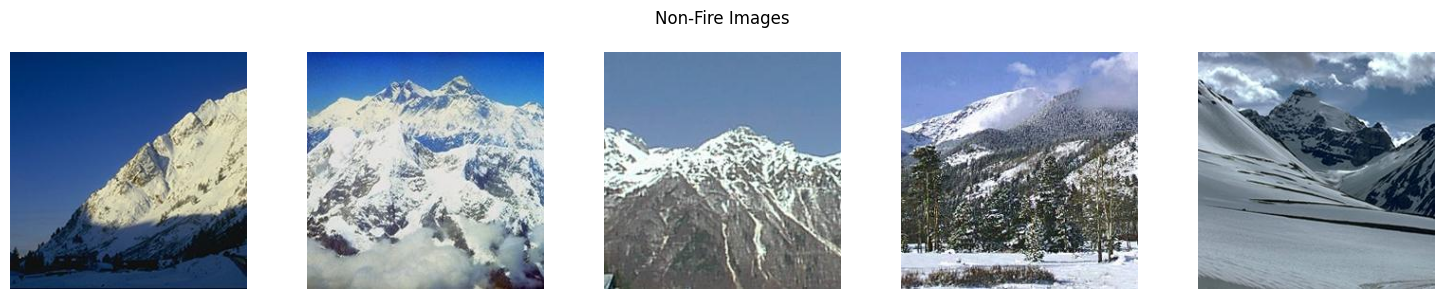

In [6]:
show_label_images(title='Non-Fire Images', images=negative_images, path=negative_path)

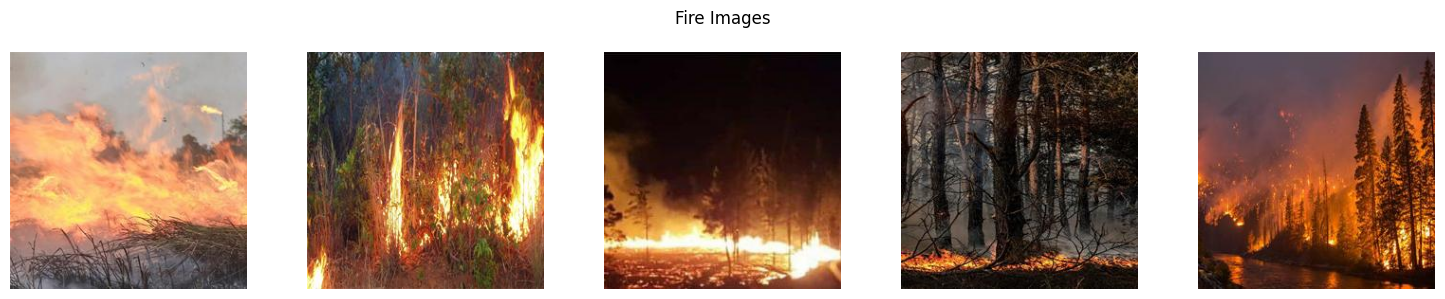

In [7]:
show_label_images(title='Fire Images', images=positive_images, path=positive_path)

## 1.4 Dimensions Distributions

I need to check if photo dimensions are already standardized and doesn't require additional step of preprocessing.

In [8]:
image_shapes = []
for img_name in negative_images:
    img = Image.open(os.path.join(negative_path, img_name))
    image_shapes.append(img.size)
for img_name in positive_images:
    img = Image.open(os.path.join(positive_path, img_name))
    image_shapes.append(img.size)

unique_shapes = set(image_shapes)
print(f"Unique image dimensions: {unique_shapes}")

Unique image dimensions: {(250, 250)}


All of the photos are 250x250 what means that there is no need to standardize the dimension.

## 1.5 Data Clusterization

I want to group visually similar photos into clusters and look at these clusters to get a sense of general types of photos in the dataset and see how it correlates with labels.

### 1.5.1 Build Clusters

I'm loading a random sample of every label, generate embeddings using VGG16, reduce dimensionality using PCA and then clusterize them using KMeans.

In [9]:
def load_images(image_list, image_dir, img_size=(224,224)):
    images = []
    for img_name in image_list:
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = img.resize(img_size)
        img = np.array(img)
        images.append(img)
    return np.array(images)

sample_size = 400
sample_negatives = random.sample(negative_images, sample_size // 2)
sample_positives = random.sample(positive_images, sample_size // 2)

neg_images = load_images(sample_negatives, negative_path)
pos_images = load_images(sample_positives, positive_path)

X = np.concatenate((neg_images, pos_images), axis=0)
y = np.array([0]*(sample_size//2) + [1]*(sample_size//2))

In [10]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
features = model.predict(preprocess_input(X))
features = features.reshape(features.shape[0], -1)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step


In [11]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(features)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_pca)


### 1.5.2 Clusters Overview

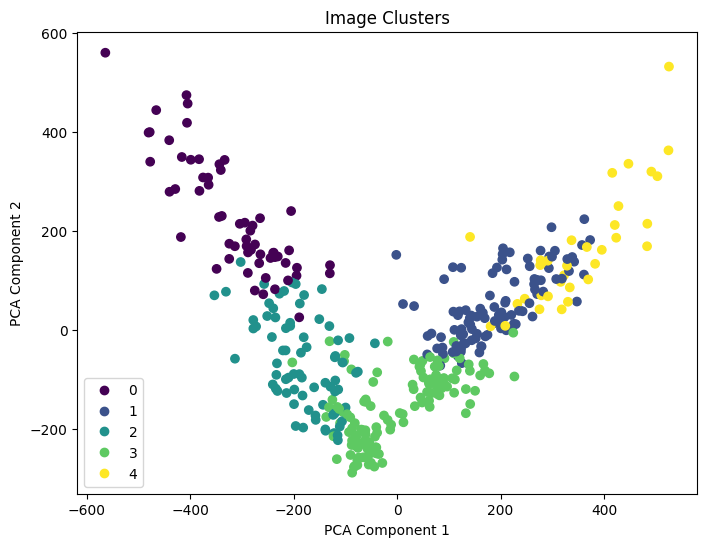

In [12]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis')
plt.title('Image Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters))
plt.show()


### 1.5.3 Clusters vs Labels

I'm comparing how cluster correlates with label.

In [13]:
df_clusters = pd.DataFrame({'Cluster': clusters, 'Label': y})
cluster_counts = df_clusters.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)
print(cluster_counts)


Label     0    1
Cluster         
0        59    0
1         0  106
2        74    1
3        67   59
4         0   34


We cab see that some clusters itself are label predictors when some clusters are mixed.

### 1.5.4 Clusters Analysis

I'm looking at photos in these clusters.


Cluster 0: 59 images


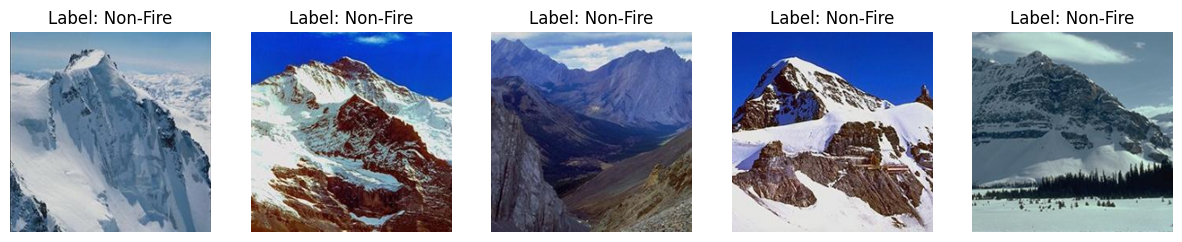


Cluster 1: 106 images


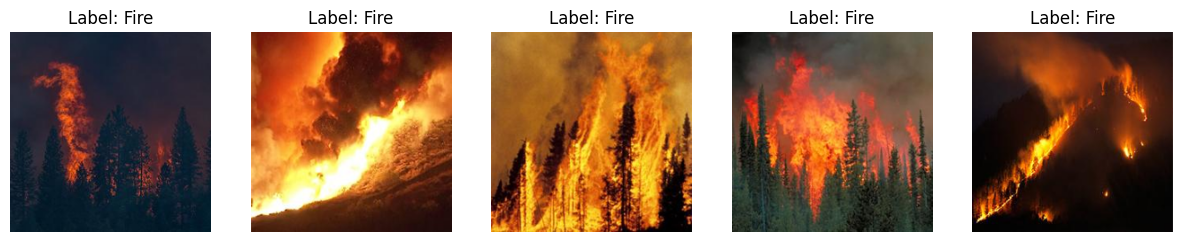


Cluster 2: 75 images


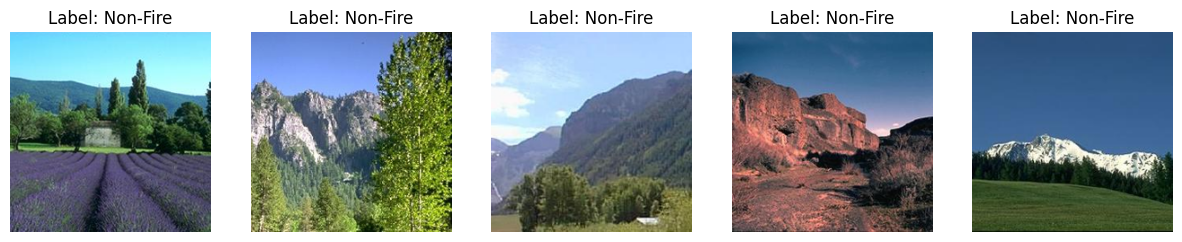


Cluster 3: 126 images


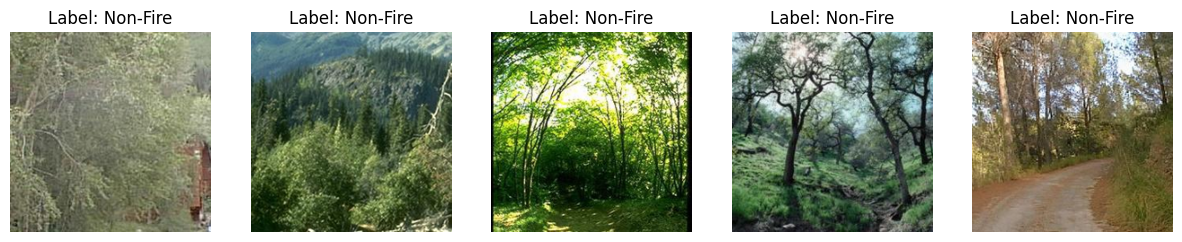


Cluster 4: 34 images


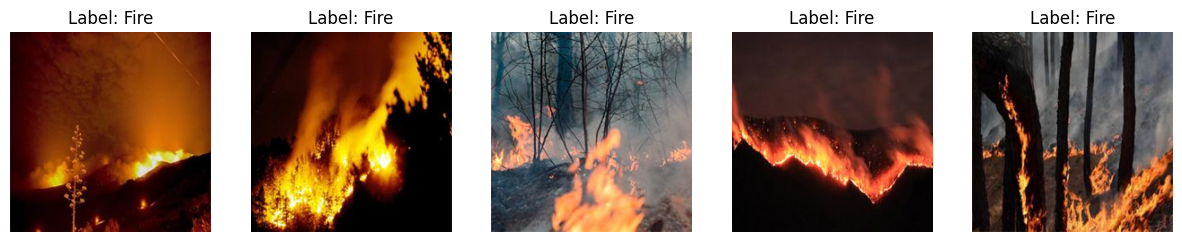

In [14]:
for cluster_num in range(5):
    indices = np.where(clusters == cluster_num)[0]
    cluster_labels = y[indices]
    print(f"\nCluster {cluster_num}: {len(indices)} images")
    plt.figure(figsize=(15,3))
    images_in_cluster = X[indices]
    labels_in_cluster = cluster_labels
    for i in range(5):
        if i >= len(images_in_cluster):
            break
        img = images_in_cluster[i]
        label = 'Fire' if labels_in_cluster[i] == 1 else 'Non-Fire'
        plt.subplot(1,5,i+1)
        plt.imshow(img.astype('uint8'))
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()


First cluster contains "cold" photos with water or snow. Clusters 3 and 4 are interesting. It seems like cluster 3 doesn't cointain sky when in cluster 4 we can see that it contains sky and mixes fire smoke and fog/sky that's a very important sign of prediction unconfidence.

# 2. Data Preprocessing
## 2.1 Data Augmentation

1000 samples is not really big dataset. I'm using data augmentation to expand it. For example, I generate random horizontal flips, shift images, rotate them, zoom etc to expand the dataset.

At this step, I'm also making train/test split using generators.

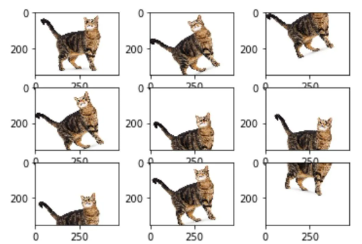

In [16]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

generator_common_params = {
    'directory': path,
    'target_size': (IMG_HEIGHT, IMG_WIDTH),
    'batch_size': BATCH_SIZE,
    'classes': ['non_fire_images', 'fire_images'],
    'class_mode': 'binary',
}

train_generator = train_datagen.flow_from_directory(
    **generator_common_params,
    subset='training',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    **generator_common_params,
    subset='validation',
    shuffle=False
)


Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.


# 3. Models

## 3.0 Hyperparateter Optimization Approach

I will use 2 architectures: CNN and VGG16 transfer learning. For VGG16 I will use 2 types of optimizer: Adam and RMSProp. Basically I have 2 hyperparamters: architecture and optimizer. CNN doesn't need optimizer. Therefore I have 3 combinations of params: CNN, VGG16-Adam, VGG16-RMSProp. The only hyperparameter I will optimize actually is what combinations performs better.

## 3.1 Different Models Architecture
### 3.1.1 Convolutional Neural Network (CNN) Architcture

In [17]:
model1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.1.2 VGG16 Transfer Learning Architcture

In [18]:
base_model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                   include_top=False,
                   weights='imagenet')

for layer in base_model.layers[:-4]:
    layer.trainable = False

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

### 3.1.3 RMSprop VGG16 Architcture

In [19]:
from tensorflow.keras.optimizers import RMSprop

model3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

optimizer = RMSprop(learning_rate=0.0001)
model3.compile(optimizer=optimizer,
               loss='binary_crossentropy',
               metrics=['accuracy'])

## 3.2 Models Training


In [20]:
history1 = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 475ms/step - accuracy: 0.7598 - loss: 0.8138 - val_accuracy: 0.9014 - val_loss: 0.2878
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 352ms/step - accuracy: 0.9520 - loss: 0.1869 - val_accuracy: 0.9205 - val_loss: 0.2159
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 356ms/step - accuracy: 0.9529 - loss: 0.1579 - val_accuracy: 0.9233 - val_loss: 0.2152
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.9549 - loss: 0.1292 - val_accuracy: 0.9288 - val_loss: 0.2033
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.9646 - loss: 0.1152 - val_accuracy: 0.9288 - val_loss: 0.2573
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - accuracy: 0.9638 - loss: 0.0973 - val_accuracy: 0.8822 - val_loss: 0.4760
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.9639 - loss: 0.1422 - val_accuracy: 0.8849 - val_loss: 0.2839
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.9587 - loss: 0.1254 - val_accuracy: 0.926

In [21]:
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 912ms/step - accuracy: 0.6506 - loss: 0.6140 - val_accuracy: 0.9452 - val_loss: 0.1650
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 423ms/step - accuracy: 0.9626 - loss: 0.1255 - val_accuracy: 0.9260 - val_loss: 0.1924
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.9679 - loss: 0.1364 - val_accuracy: 0.9671 - val_loss: 0.0952
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - accuracy: 0.9748 - loss: 0.0713 - val_accuracy: 0.9699 - val_loss: 0.1070
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.9812 - loss: 0.0378 - val_accuracy: 0.9699 - val_loss: 0.1020
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - accuracy: 0.9865 - loss: 0.0487 - val_accuracy: 0.9726 - val_loss: 0.0849
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 418ms/step - accuracy: 0.9863 - loss: 0.0483 - val_accuracy: 0.9671 - val_loss: 0.1358
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.9745 - loss: 0.0876 - val_accu

In [22]:
history3 = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 464ms/step - accuracy: 0.7456 - loss: 0.5992 - val_accuracy: 0.9644 - val_loss: 0.0899
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - accuracy: 0.9937 - loss: 0.0310 - val_accuracy: 0.9671 - val_loss: 0.1143
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 418ms/step - accuracy: 0.9920 - loss: 0.0245 - val_accuracy: 0.9726 - val_loss: 0.1252
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 446ms/step - accuracy: 0.9971 - loss: 0.0077 - val_accuracy: 0.9726 - val_loss: 0.1477
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - accuracy: 0.9969 - loss: 0.0139 - val_accuracy: 0.9726 - val_loss: 0.1286
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.9971 - loss: 0.0091 - val_accuracy: 0.9671 - val_loss: 0.1355
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 422ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9753 - val_loss: 0.1560
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 432ms/step - accuracy: 0.9968 - loss: 0.0115 - val_accu

## 3.3 Models Training Evaluation


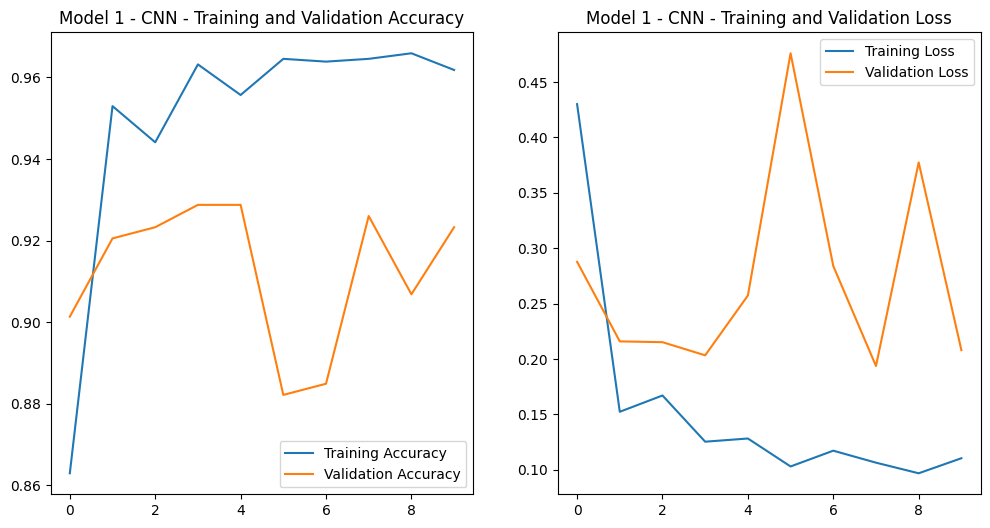

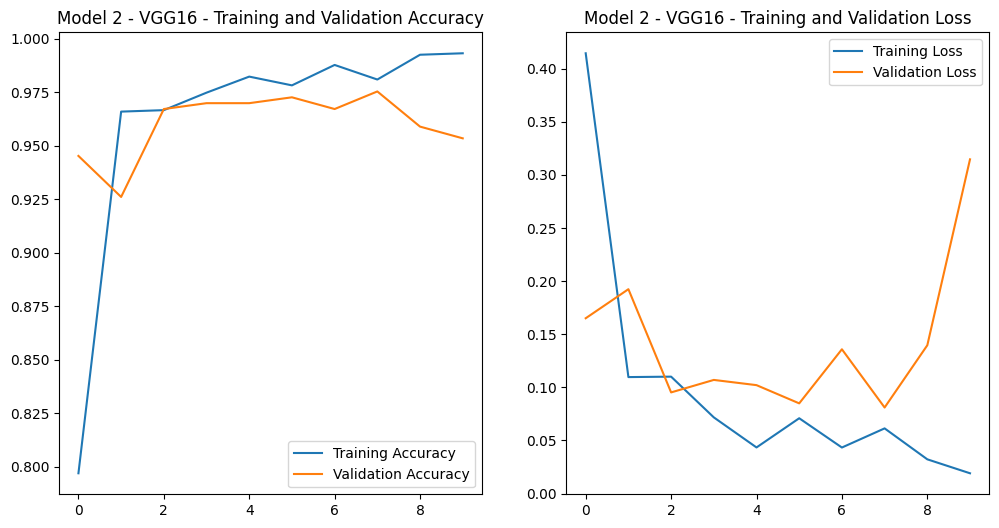

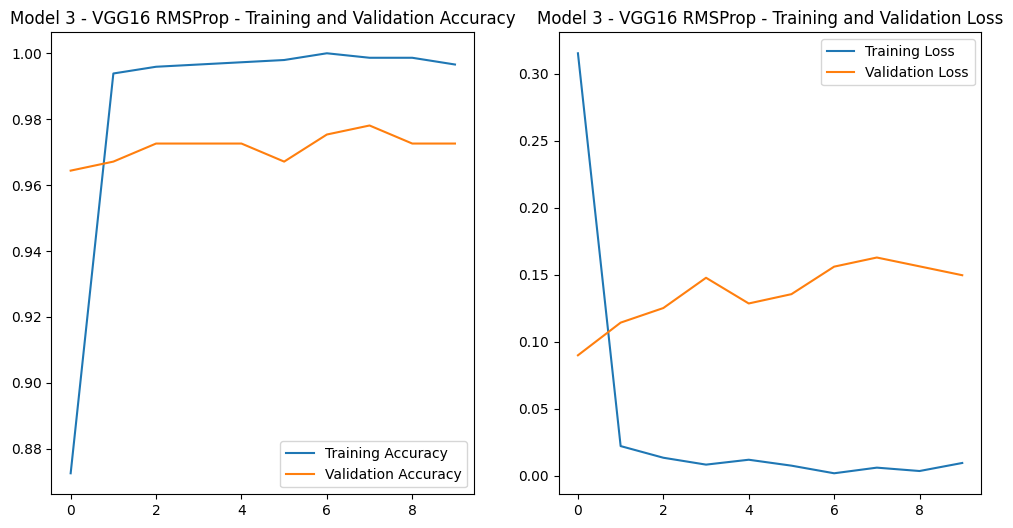

In [23]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Training and Validation Loss')
    plt.show()

plot_history(history1, 'Model 1 - CNN')
plot_history(history2, 'Model 2 - VGG16')
plot_history(history3, 'Model 3 - VGG16 RMSProp')

# 4. Models Evaluation
## 4.1 Run Models

The model actually predicts probability of the class but I treat this as a binary classification problem and convert probability >0.5 into 1 to get 0/1 predictions instead of probabilities.

In [24]:
validation_generator.reset()
preds1 = model1.predict(validation_generator)
preds2 = model2.predict(validation_generator)
preds3 = model3.predict(validation_generator)

y_true = validation_generator.classes
y_pred1 = (preds1 > 0.5).astype(int)
y_pred2 = (preds2 > 0.5).astype(int)
y_pred3 = (preds3 > 0.5).astype(int)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step


## 4.2 Classification Metric Reports


In [25]:
print("Model 1 Classification Report")
print(classification_report(y_true, y_pred1))

print("Model 2 Classification Report")
print(classification_report(y_true, y_pred2))

print("Model 3 Classification Report")
print(classification_report(y_true, y_pred3))

Model 1 Classification Report
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       180
           1       0.91      0.94      0.93       185

    accuracy                           0.92       365
   macro avg       0.92      0.92      0.92       365
weighted avg       0.92      0.92      0.92       365

Model 2 Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       180
           1       0.98      0.97      0.98       185

    accuracy                           0.98       365
   macro avg       0.98      0.98      0.98       365
weighted avg       0.98      0.98      0.98       365

Model 3 Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       180
           1       0.98      0.97      0.97       185

    accuracy                           0.97       365
   macro avg       0.97      0.97     

All of the models demonstrate 0.9+ F1 score. Second model that is VGG16 with tranfer learning demonstrates the best F1 score, the best balanced prediction.

Also, we are fine to predict fire for non-fire cases, it's more important to catch all of the fire cases therefore we should focus on recall for class 1 and model 2/3 gives the best 0.97 recall.

## 4.3 Confusion Matrices

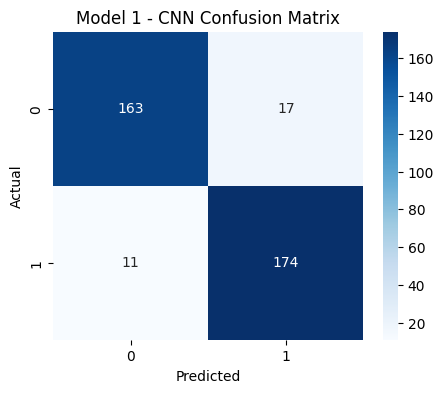

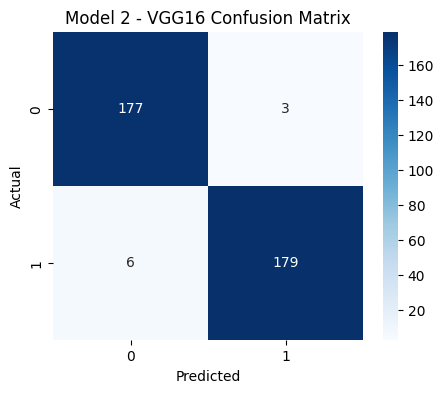

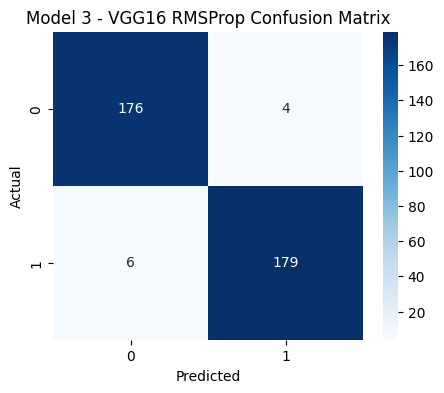

In [30]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(y_true, y_pred3)

def plot_cm(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_cm(cm1, 'Model 1 - CNN')
plot_cm(cm2, 'Model 2 - VGG16')
plot_cm(cm3, 'Model 3 - VGG16 RMSProp')

Models 2/3 (VGG16) also shows the best result in terms of maximizing sensibility to fire cases.

## 4.4 ROC AUC Curves


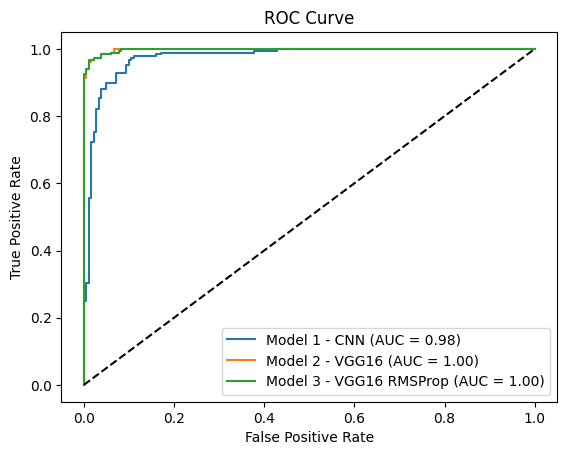

In [27]:
fpr1, tpr1, _ = roc_curve(y_true, preds1)
fpr2, tpr2, _ = roc_curve(y_true, preds2)
fpr3, tpr3, _ = roc_curve(y_true, preds3)

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

plt.figure()
plt.plot(fpr1, tpr1, label='Model 1 - CNN (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, label='Model 2 - VGG16 (AUC = %0.2f)' % auc2)
plt.plot(fpr3, tpr3, label='Model 3 - VGG16 RMSProp (AUC = %0.2f)' % auc3)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Models 2 and 3 also show perfect AUC=1.

# 5. Results & Conclusion

I successfully created a computer vision model using deep machine learning architecture with good classification balance (F1), high accuracy and sensibility to "fire" cases that should trigger alarms. I made EDA using clusterization method and solved a problem of the small dataset using data augmentation. I compared different models and combinations of hyperparaters applying different model evaluation methods and chosen the best one.

## 5.1 Model Inference Demo

In [28]:
def predict_image(model, img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((IMG_HEIGHT, IMG_WIDTH))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    probability = prediction[0][0]
    if probability > 0.5:
        print(f"Prediction: Fire ({probability*100:.2f}% confidence)")
    else:
        print(f"Prediction: Non-Fire ({(1-probability)*100:.2f}% confidence)")

In [31]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}"')
    predict_image(model1, filename)

Saving forest_fire_test.jpg to forest_fire_test.jpg
User uploaded file "forest_fire_test.jpg"
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
Prediction: Fire (96.56% confidence)
